## Imports


In [11]:
import numpy as np
import pandas as pd
import ast
import seaborn as sns
import matplotlib.pyplot as plt
import re

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_seq_items', None)

In [12]:
df = pd.read_csv('data/combined.csv')

In [13]:
def parse_vectors(s):
    parsed = ast.literal_eval(s)
    vector = []
    for tup in parsed:
        m = re.search(r'([ES])(\d+)', tup[1])
        sign, num = m.groups()
        value = (-1 if sign == 'E' else 1) * int(num)
        vector.append(value)
    return vector

In [14]:
df["Input List"] = df["Input List"].apply(parse_vectors)

## Generating New Features


In [15]:
def max_consecutive_by_condition(vals, condition):
    max_len = curr_len = 0
    for v in vals:
        if condition(v):
            curr_len += 1
            max_len = max(max_len, curr_len)
        else:
            curr_len = 0
    return max_len

def extract_blocks(vals):
    blocks = []
    curr_len = 0
    curr_sign = 0
    for v in vals:
        sign = 1 if v > 0 else -1 if v < 0 else 0
        if sign == 0:
            if curr_len:
                blocks.append(curr_len)
            curr_len = 0
            curr_sign = 0
        else:
            if sign != curr_sign:
                if curr_len:
                    blocks.append(curr_len)
                curr_len = 1
                curr_sign = sign
            else:
                curr_len += 1
    if curr_len:
        blocks.append(curr_len)
    return blocks

def max_block_size(vals):
    blocks = extract_blocks(vals)
    return max(blocks) if blocks else 0

def min_block_size(vals):
    blocks = extract_blocks(vals)
    return min(blocks) if blocks else 0

def mean_block_size(vals):
    blocks = extract_blocks(vals)
    return sum(blocks) / len(blocks) if blocks else 0

def std_block_size(vals):
    blocks = extract_blocks(vals)
    return np.std(blocks) if blocks else 0

def count_transitions(vals):
    transitions = 0
    last_sign = 0
    for v in vals:
        current_sign = 1 if v > 0 else -1 if v < 0 else 0
        if last_sign != 0 and current_sign != 0 and current_sign != last_sign:
            transitions += 1
        if current_sign:
            last_sign = current_sign
    return transitions

def blockiness(vals):
    signs = [1 if v > 0 else -1 if v < 0 else 0 for v in vals]
    filtered = [s for s in signs if s != 0]
    if len(filtered) < 2:
        return 0
    same_pairs = sum(1 for i in range(1, len(filtered)) if filtered[i] == filtered[i - 1])
    return same_pairs / (len(filtered) - 1)

def gini_coefficient(vals):
    arr = np.abs(np.array(vals, dtype=float))
    if arr.sum() == 0:
        return 0
    arr_sorted = np.sort(arr)
    n = len(arr)
    i = np.arange(1, n + 1)
    return (2 * (i * arr_sorted).sum()) / (n * arr.sum()) - (n + 1) / n

def fft_stats(vals):
    arr = np.array(vals, dtype=float)
    ft = np.fft.fft(arr)
    abs_ft = np.abs(ft)
    return {
        'max': np.max(abs_ft),
        'mean': np.mean(abs_ft),
        'sum': np.sum(abs_ft),
        'std': np.std(abs_ft)
    }

def hydrophobic_hydrophilic_ratio(vector):
    vector = np.array(vector)
    pos = np.sum(vector > 0)
    neg = np.sum(vector < 0)
    total = pos + neg
    return pos / total if total else 0.0

def hydrophobic_hydrophilic_ratio_weighted(vector):
    vector = np.array(vector)
    pos = np.sum(vector[vector > 0])
    neg = np.sum(np.abs(vector[vector < 0]))
    total = pos + neg
    return pos / total if total else 0.0

def harwoods_blockiness(vals):
    n = len(vals)
    if n < 2:
        return 0
    count_A = sum(1 for m in vals if m > 0)
    P_A = count_A / n
    count_AA = sum(1 for i in range(n - 1) if vals[i] > 0 and vals[i+1] > 0)
    P_AA = count_AA / (n - 1)
    if 1 - P_A == 0:
        return 0
    return (P_AA - P_A) / (1 - P_A)

def mayo_lewis(vals, r1, r2):
    n = len(vals)
    if n == 0:
        return None
    count_M1 = sum(1 for m in vals if m > 0)
    count_M2 = sum(1 for m in vals if m < 0)
    if count_M2 == 0:
        return None
    M1 = count_M1 / n
    M2 = count_M2 / n
    denominator = M2 * (r2 * M2 + M1)
    if denominator == 0:
        return None
    return (M1 * (r1 * M1 + M2)) / denominator


df['backbone_length'] = df['Input List'].apply(len)

df['mean_charge'] = df['Input List'].apply(lambda x: np.mean(x))
df['sum_charge'] = df['Input List'].apply(lambda x: np.sum(x))
df['max_charge'] = df['Input List'].apply(lambda x: np.max(x))
df['min_charge'] = df['Input List'].apply(lambda x: np.min(x))
df['std_charge'] = df['Input List'].apply(lambda x: np.std(x))

df['mean_length'] = df['Input List'].apply(lambda x: np.mean(np.abs(x)))
df['max_length'] = df['Input List'].apply(lambda x: np.max(np.abs(x)))
df['std_length'] = df['Input List'].apply(lambda x: np.std(np.abs(x)))

df['max_S_block'] = df['Input List'].apply(lambda x: max_consecutive_by_condition(x, lambda v: v > 0))
df['max_E_block'] = df['Input List'].apply(lambda x: max_consecutive_by_condition(x, lambda v: v < 0))

df['transitions'] = df['Input List'].apply(lambda x: count_transitions(x))
df['max_block_size'] = df['Input List'].apply(lambda x: max_block_size(x))
df['min_block_size'] = df['Input List'].apply(lambda x: min_block_size(x))
df['mean_block_size'] = df['Input List'].apply(lambda x: mean_block_size(x))
df['std_block_size'] = df['Input List'].apply(lambda x: std_block_size(x))
df['blockiness'] = df['Input List'].apply(lambda x: blockiness(x))
df['gini'] = df['Input List'].apply(lambda x: gini_coefficient(x))

df['max_fft_value'] = df['Input List'].apply(lambda x: fft_stats(x)['max'])
df['mean_fft_value'] = df['Input List'].apply(lambda x: fft_stats(x)['mean'])
df['sum_fft_value'] = df['Input List'].apply(lambda x: fft_stats(x)['sum'])
df['std_fft_value'] = df['Input List'].apply(lambda x: fft_stats(x)['std'])

df['hydrophobic_ratio'] = df['Input List'].apply(lambda x: hydrophobic_hydrophilic_ratio(x))
df['hydrophobic_ratio_weighted'] = df['Input List'].apply(lambda x: hydrophobic_hydrophilic_ratio_weighted(x))

df['harwoods_blockiness'] = df['Input List'].apply(lambda x: harwoods_blockiness(x))
df['mayo_lewis'] = df['Input List'].apply(lambda x: mayo_lewis(x, r1=1, r2=1))


In [16]:
df.to_csv('data/feature.csv', index=False)

## Display New DF and Correlation Matrices


In [17]:
display(df)

,Name,Input List,Start Frame,Area AVG,Area STD,RG AVG,RG STD,RDF Peak,Coordination at Minimum,backbone_length,...,blockiness,gini,max_fft_value,mean_fft_value,sum_fft_value,std_fft_value,hydrophobic_ratio,hydrophobic_ratio_weighted,harwoods_blockiness,mayo_lewis
0,polymerA1,"[-4, -4, -4, -4, -4, -4, -4, -4, -4, -4, 6, 4, 6, 4, 6, 4, 6, 4, 6, 4]",830.0,13932.257425,320.245717,18.827689,0.130057,1.772309,3.773179,20,...,0.947368,0.083333,57.540987,12.167233,243.344657,16.491163,0.500000,0.555556,-0.052632,1.000000
1,polymerA2,"[-4, -4, -4, -4, -4, -4, -4, -4, -4, -4, 8, 2, 8, 2, 8, 2, 8, 2, 8, 2]",830.0,13925.018799,271.369585,19.595126,0.088104,1.807134,4.246339,20,...,0.947368,0.250000,57.612203,14.443927,288.878538,17.069651,0.500000,0.555556,-0.052632,1.000000
2,polymerA3,"[-4, -4, -4, -4, -4, -4, -4, -4, -4, -4, 10, 0, 10, 0, 10, 0, 10, 0, 10, 0]",830.0,13562.258674,260.499731,20.872170,0.207960,1.763469,4.242929,20,...,0.928571,0.416667,57.754370,17.109759,342.195181,19.163928,0.333333,0.555556,-0.333333,0.500000
3,polymerA4,"[-4, -4, -4, -4, -4, -4, -4, -4, -4, -4, 0, 0, 0, 0, 0, 0, 0, 0, 10, 40]",830.0,12578.201381,246.681083,21.968153,0.196716,1.760656,3.725571,20,...,0.909091,0.650000,60.554352,41.636304,832.726078,11.243585,0.166667,0.555556,-0.052632,0.200000
4,polymerA5,"[-4, -4, -4, -4, -4, -4, -4, -4, -4, -4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 50]",830.0,12742.920513,242.018364,22.440286,0.162869,1.776060,4.213018,20,...,0.900000,0.705556,59.613885,50.637165,1012.743309,9.791704,0.090909,0.555556,-0.052632,0.100000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
368,polymerP152,"[6, 6, -3, -1, 7, 0, 5, 0, -8, -9, 5, 3, 1]",830.0,10932.110000,260.340000,17.800000,0.110000,1.820000,4.240000,13,...,0.600000,0.401709,27.517275,16.395757,213.144844,8.196289,0.636364,0.611111,-0.625000,1.750000
369,polymerP153,"[8, 6, 2, -8, -1, 7, 0, 9, 4, -8, -7, -8, -7, 4, -3]",830.0,13610.080000,405.350000,18.470000,0.120000,1.930000,4.380000,15,...,0.615385,0.282927,44.080664,21.157041,317.355608,10.880241,0.500000,0.487805,-0.473214,1.000000
370,polymerP155,"[7, -7, -4, 8, -1, 3, 4, 5, -9, -3, 0, -5, 2, -3]",830.0,12193.960000,305.700000,16.650000,0.280000,1.870000,4.610000,14,...,0.416667,0.331382,28.912513,15.739321,220.350492,10.453410,0.461538,0.475410,-0.480769,0.857143
371,polymerP156,"[2, -2, -9, -8, -8, 8, 6, 9, -3, 7, 0, 4, -8, -7]",547.0,13440.570000,406.750000,17.580000,0.160000,1.900000,4.030000,14,...,0.583333,0.272487,39.240831,21.291977,298.087679,11.473958,0.461538,0.444444,-0.480769,0.857143


In [ ]:
#Calculating Correlation Coefficients
temp = df
left_cols = temp.columns[3:9]
right_cols = temp.columns[9:]
temp[left_cols] = temp[left_cols].apply(pd.to_numeric, errors="coerce")
left_num = temp[left_cols].select_dtypes(include=[float, int])
right_num = temp[right_cols].select_dtypes(include=[float, int])
corr_dict = {c: left_num.corrwith(right_num[c]) for c in right_num.columns}
corr_df = pd.DataFrame(corr_dict)

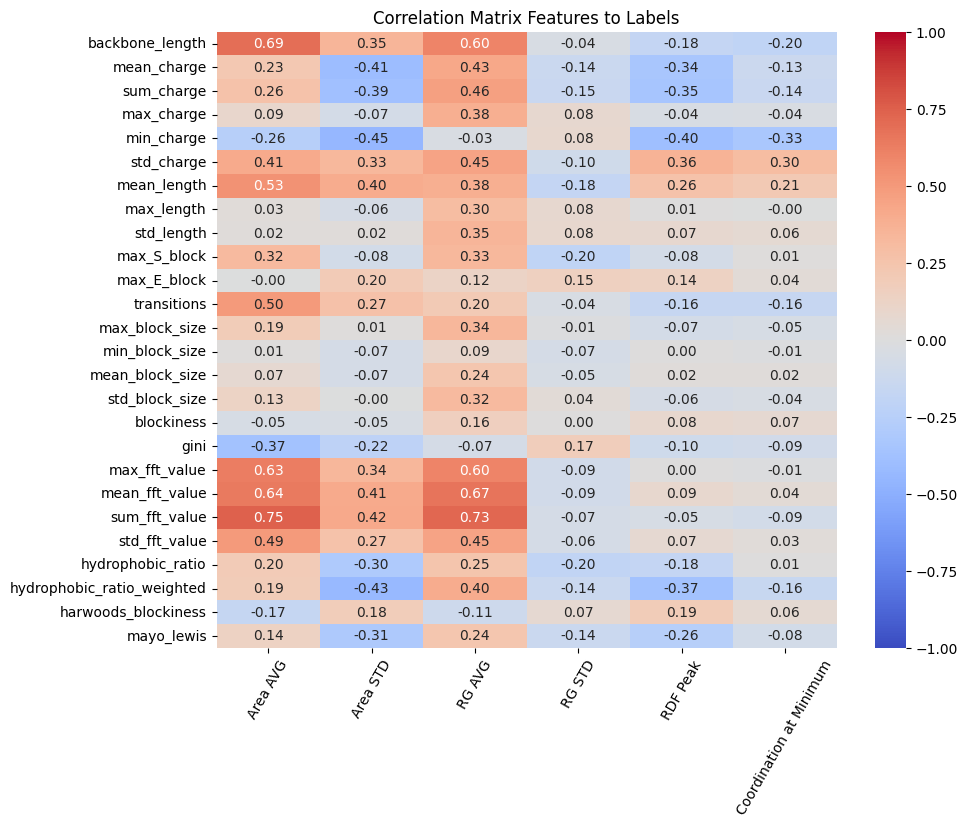

In [22]:
#Correlation Matrix Features to Labels
plt.figure(figsize=(10, 8))
sns.heatmap(corr_df.T, cmap="coolwarm", annot=True, fmt=".2f", vmin=-1, vmax=1)
plt.xticks(rotation=60)
plt.title("Correlation Matrix Features to Labels")
plt.show()

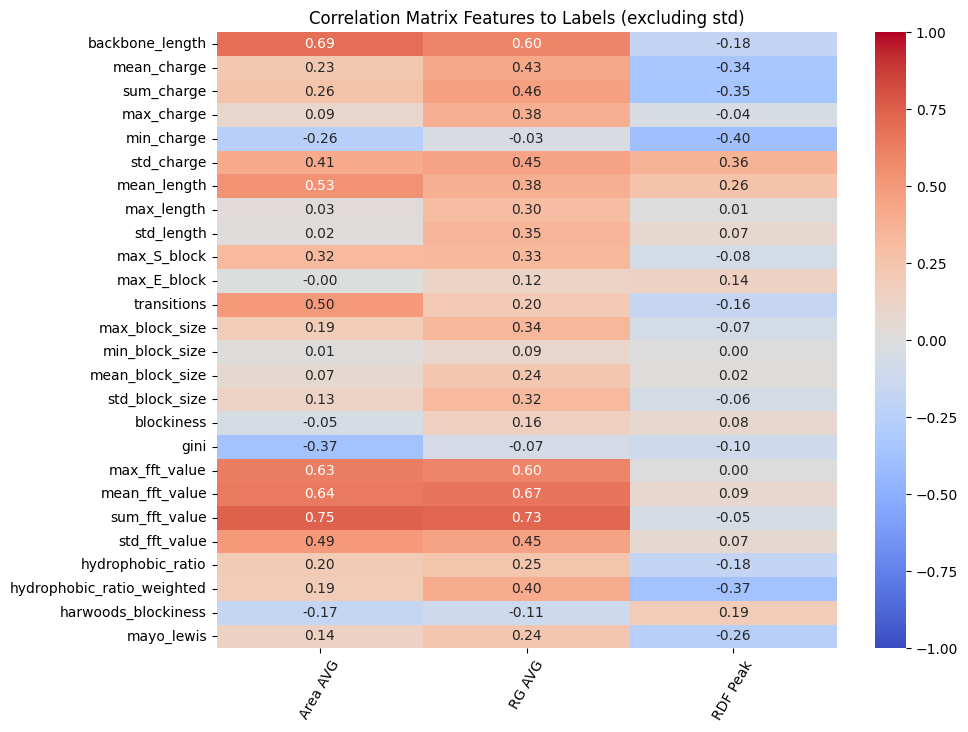

In [24]:
#Correlation Matrix Features to Labels (excluding std)
plt.figure(figsize=(10, 8))
sns.heatmap(corr_df.drop(["RG STD", "Area STD", "Coordination at Minimum"], axis=0).T, cmap="coolwarm", annot=True, fmt=".2f", vmin=-1, vmax=1)
plt.xticks(rotation=60)
plt.title("Correlation Matrix Features to Labels (excluding std)")
plt.show()

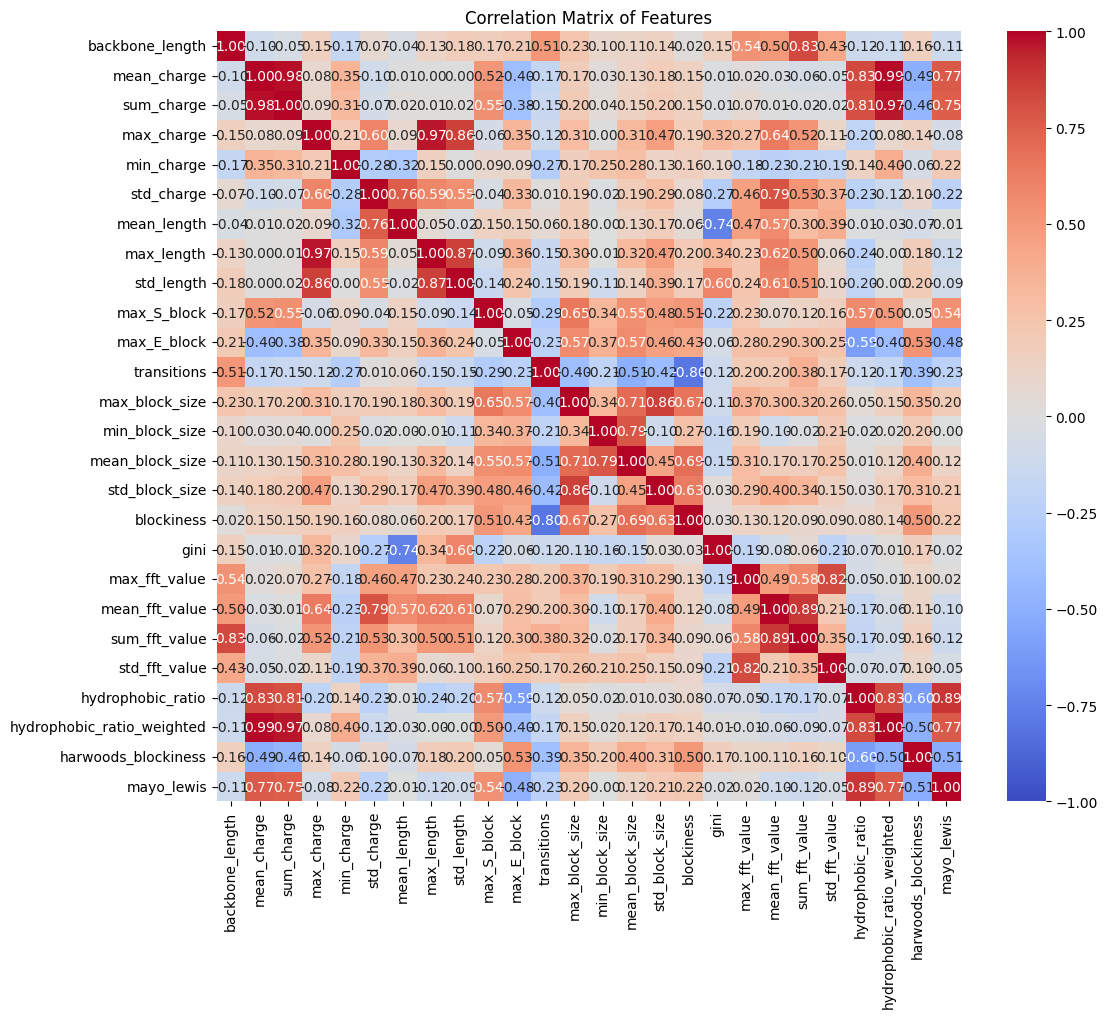

In [25]:
#Correlation Matrix of Features, useful for linear combinations
plt.figure(figsize=(12, 10))
sns.heatmap(df[right_cols].corr(), annot=True, cmap="coolwarm", fmt=".2f", vmin=-1, vmax=1)
plt.title("Correlation Matrix of Features")
plt.show()